In [1]:
__imp

Libraries have been loaded


## Load Additional Libraries

In [2]:
basepath = os.path.expanduser('../')

## Load Data

In [3]:
%%time

app_train = pd.read_pickle(os.path.join(basepath, 'data/interim/dataset1/application_train.pkl'))
# app_test  = pd.read_pickle(os.path.join(basepath, 'data/interim/dataset1/application_test.pkl'))

# bureau       = pd.read_pickle(os.path.join(basepath, 'data/interim/dataset1/bureau.pkl'))
# bureau_bal   = pd.read_pickle(os.path.join(basepath, 'data/interim/dataset1/bureau_balance.pkl'))
# prev_app     = pd.read_pickle(os.path.join(basepath, 'data/interim/dataset1/previous_application.pkl'))
# installments = pd.read_pickle(os.path.join(basepath, 'data/interim/dataset1/installments_payments.pkl')) 
# pos_cash     = pd.read_pickle(os.path.join(basepath, 'data/interim/dataset1/POS_CASH_balance.pkl'))
credit_bal   = pd.read_pickle(os.path.join(basepath, 'data/interim/dataset1/credit_card_balance.pkl'))

CPU times: user 109 ms, sys: 364 ms, total: 474 ms
Wall time: 5.56 s


### Feature Statistics

In [23]:
for col in app_test.columns:
    if app_train[col].nunique() < 100:
        print('Feature Name: {}'.format(col))
        print('Number of unique values in train: {}'.format(app_train.loc[:, col].nunique()))
        print('Number of unique values in test: {}'.format(app_train.loc[:, col].nunique()))  

        print('Values in train not in test: {}'.format(set(app_train[col].unique()) - set(app_test[col].unique())))
        print('Values in test not in train: {}'.format(set(app_test[col].unique()) - set(app_train[col].unique())))    

        print('*' * 100)

Feature Name: AMT_REQ_CREDIT_BUREAU_DAY
Number of unique values in train: 9
Number of unique values in test: 9
Values in train not in test: {nan, 3.0, 4.0, 5.0, 6.0, 8.0, 9.0}
Values in test not in train: {nan}
****************************************************************************************************
Feature Name: AMT_REQ_CREDIT_BUREAU_HOUR
Number of unique values in train: 5
Number of unique values in test: 5
Values in train not in test: {nan, 3.0, 4.0}
Values in test not in train: {nan}
****************************************************************************************************
Feature Name: AMT_REQ_CREDIT_BUREAU_MON
Number of unique values in train: 24
Number of unique values in test: 24
Values in train not in test: {nan, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 22.0, 23.0, 24.0, 27.0}
Values in test not in train: {nan}
****************************************************************************************************
Feature Name

Values in test not in train: set()
****************************************************************************************************
Feature Name: FLAG_DOCUMENT_7
Number of unique values in train: 2
Number of unique values in test: 2
Values in train not in test: set()
Values in test not in train: set()
****************************************************************************************************
Feature Name: FLAG_DOCUMENT_8
Number of unique values in train: 2
Number of unique values in test: 2
Values in train not in test: set()
Values in test not in train: set()
****************************************************************************************************
Feature Name: FLAG_DOCUMENT_9
Number of unique values in train: 2
Number of unique values in test: 2
Values in train not in test: set()
Values in test not in train: set()
****************************************************************************************************
Feature Name: FLAG_EMAIL
Number of unique values

Number of unique values in train: 2
Number of unique values in test: 2
Values in train not in test: set()
Values in test not in train: set()
****************************************************************************************************
Feature Name: REG_CITY_NOT_WORK_CITY
Number of unique values in train: 2
Number of unique values in test: 2
Values in train not in test: set()
Values in test not in train: set()
****************************************************************************************************
Feature Name: REG_REGION_NOT_LIVE_REGION
Number of unique values in train: 2
Number of unique values in test: 2
Values in train not in test: set()
Values in test not in train: set()
****************************************************************************************************
Feature Name: REG_REGION_NOT_WORK_REGION
Number of unique values in train: 2
Number of unique values in test: 2
Values in train not in test: set()
Values in test not in train: set()
**************

### Age

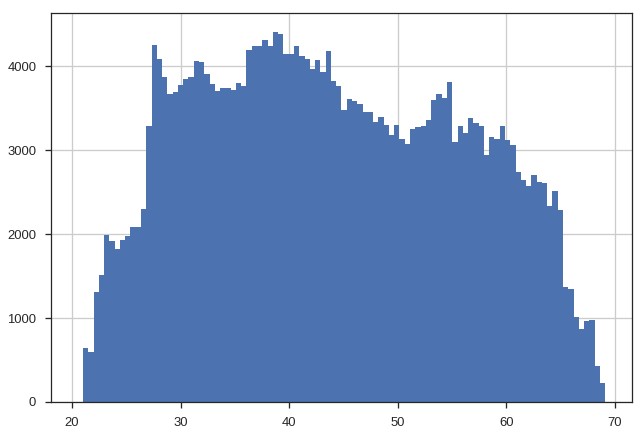

In [6]:
(-app_train.DAYS_BIRTH / 365).hist(bins=100);

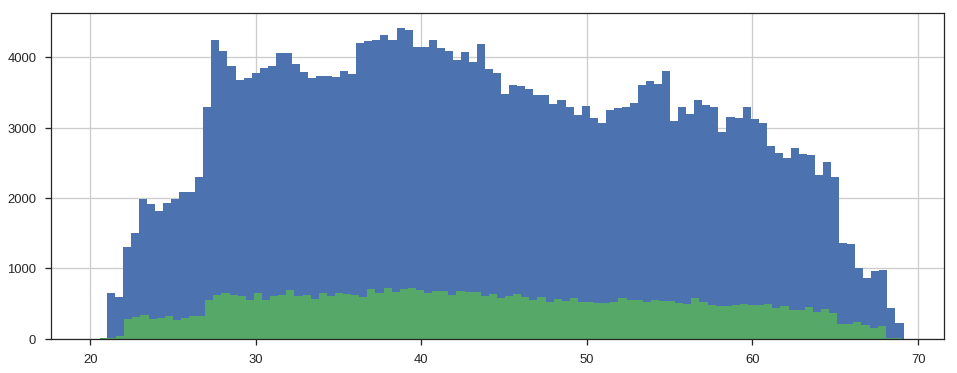

In [4]:
plt.figure(figsize=(16, 6))
(-app_train.DAYS_BIRTH / 365).hist(bins=100)
(-app_test.DAYS_BIRTH / 365).hist(bins=100);

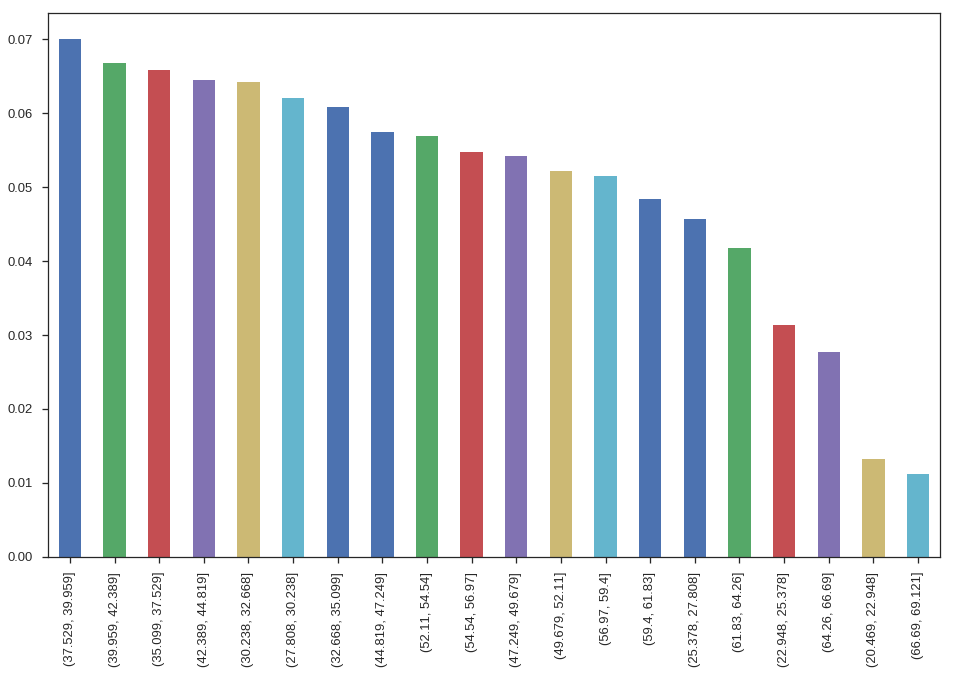

In [16]:
plt.figure(figsize=(16, 10))
pd.cut(-app_train.DAYS_BIRTH / 365, bins=20).value_counts(normalize=True).plot(kind='bar');

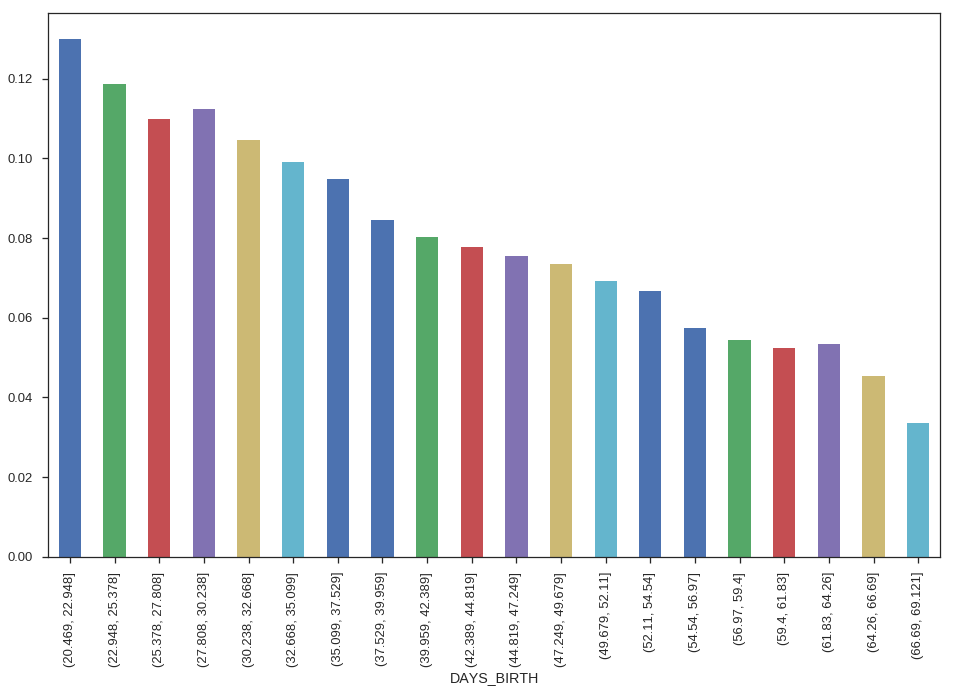

In [20]:
plt.figure(figsize=(16, 10))
app_train.groupby(pd.cut(-app_train.DAYS_BIRTH / 365, bins=20))['TARGET'].mean().plot(kind='bar');

### Days employed

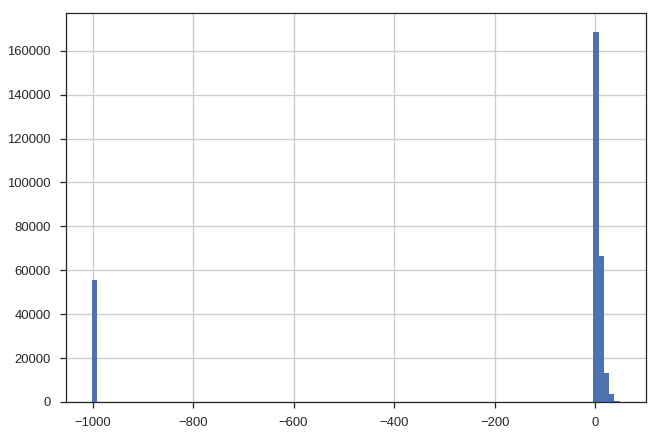

In [4]:
(-app_train.DAYS_EMPLOYED / 365).hist(bins=100);

** Interesting, missing values are filled by 365243 for days employed **

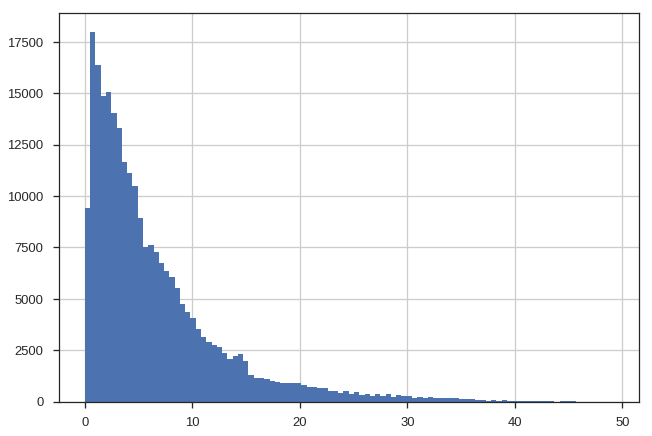

In [8]:
(-app_train.DAYS_EMPLOYED.replace({365243: np.nan}) / 365).hist(bins=100);

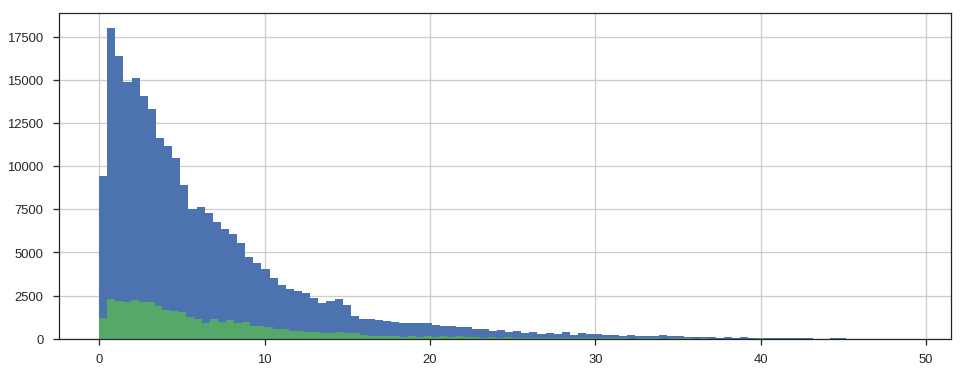

In [6]:
plt.figure(figsize=(16, 6))
(-app_train.DAYS_EMPLOYED.replace({365243: np.nan}) / 365).hist(bins=100)
(-app_test.DAYS_EMPLOYED.replace({365243: np.nan}) / 365).hist(bins=100);

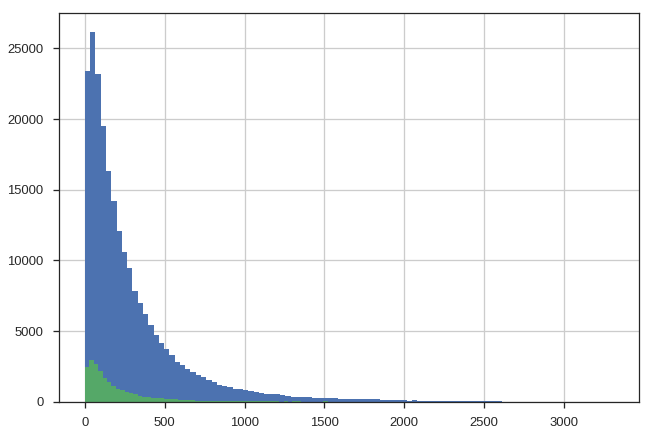

In [16]:
ss = (-app_train.DAYS_EMPLOYED.replace({365243: np.nan}) / 365) * (-app_train.DAYS_BIRTH / 365)
ss[app_train.TARGET == 0].hist(bins=100)
ss[app_train.TARGET == 1].hist(bins=100);

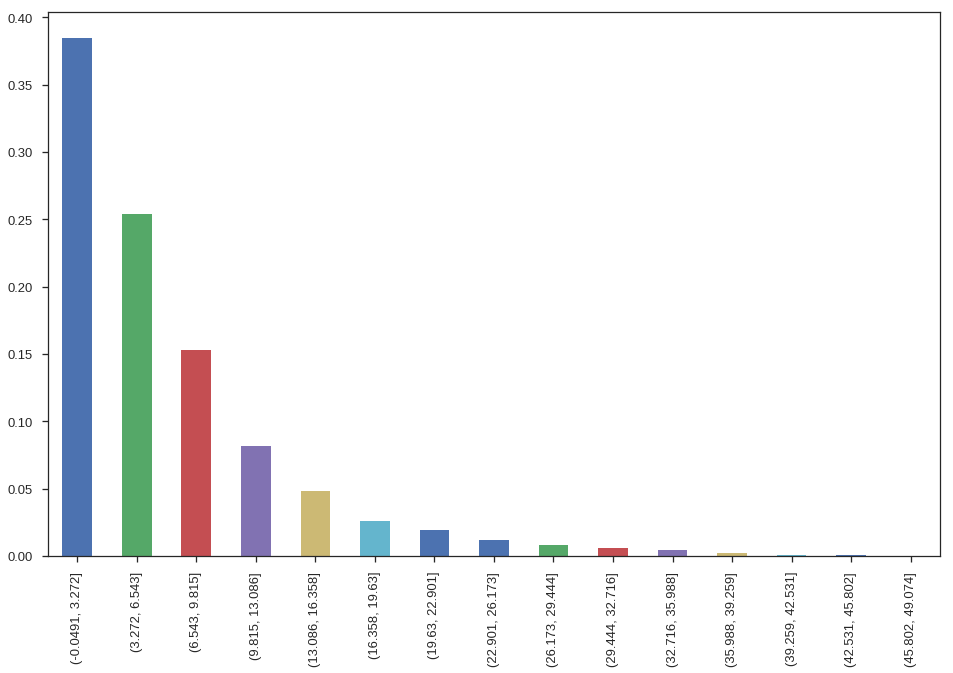

In [11]:
plt.figure(figsize=(16, 10))
pd.cut((-app_train.DAYS_EMPLOYED.replace({365243: np.nan}) / 365), bins=15).value_counts(normalize=True).plot(kind='bar');

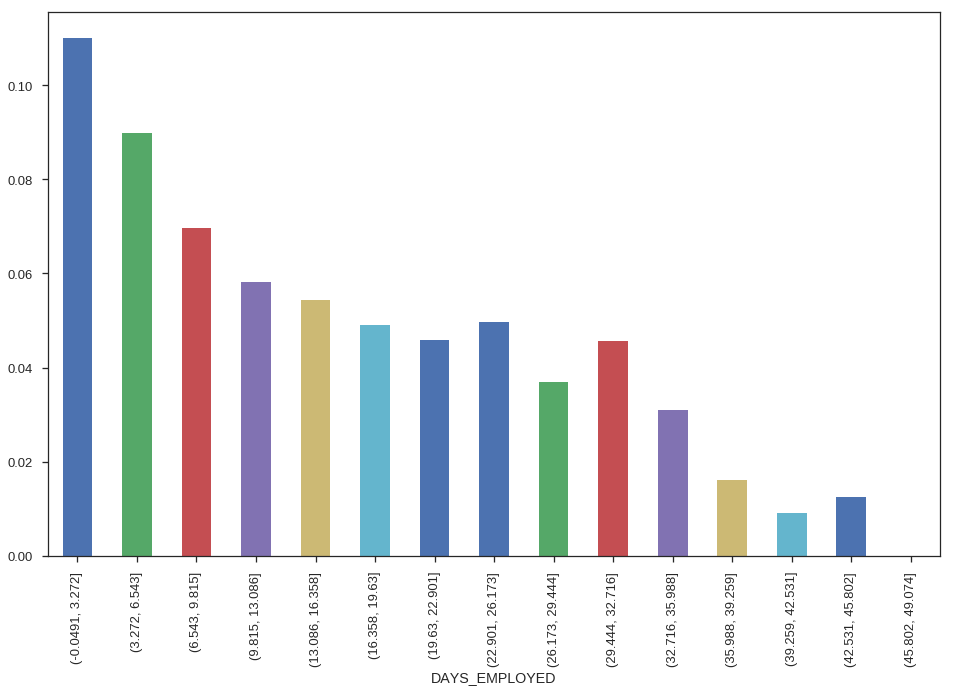

In [12]:
plt.figure(figsize=(16, 10))
app_train.groupby(pd.cut((-app_train.DAYS_EMPLOYED.replace({365243: np.nan}) / 365), bins=15))['TARGET'].mean().plot(kind='bar');

### Combine Age and days employed

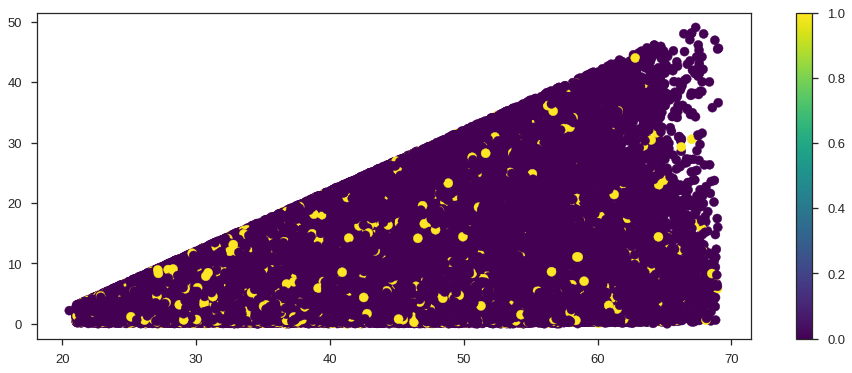

In [11]:
plt.figure(figsize=(16, 6))
plt.scatter(-app_train.DAYS_BIRTH / 365,
            -app_train.DAYS_EMPLOYED.replace({365243: np.nan}) / 365,
            c=app_train.TARGET,
            cmap='viridis'
           )
plt.colorbar();

In [4]:
age_categorical = pd.cut(-app_train.DAYS_BIRTH / 365, bins=20)
emp_categorical = pd.cut((-app_train.DAYS_EMPLOYED.replace({365243: np.nan}) / 365), bins=15)

age_emp_categorical = age_categorical.astype(np.str) + '_' + emp_categorical.astype(np.str)

In [16]:
pd.crosstab(index=age_categorical, 
            columns=emp_categorical, 
            values=app_train.TARGET, 
            aggfunc=np.sum).fillna(0)

DAYS_EMPLOYED,"(-0.0491, 3.272]","(3.272, 6.543]","(6.543, 9.815]","(9.815, 13.086]","(13.086, 16.358]","(16.358, 19.63]","(19.63, 22.901]","(22.901, 26.173]","(26.173, 29.444]","(29.444, 32.716]","(32.716, 35.988]","(35.988, 39.259]","(39.259, 42.531]","(42.531, 45.802]","(45.802, 49.074]"
DAYS_BIRTH,,,,,,,,,,,,,,,
"(20.469, 22.948]",449.0,76.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"(22.948, 25.378]",877.0,253.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"(25.378, 27.808]",946.0,469.0,126.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"(27.808, 30.238]",1150.0,659.0,283.0,45.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"(30.238, 32.668]",1064.0,591.0,273.0,112.0,11.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"(32.668, 35.099]",934.0,488.0,226.0,127.0,66.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"(35.099, 37.529]",912.0,501.0,256.0,128.0,70.0,35.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"(37.529, 39.959]",824.0,437.0,250.0,140.0,76.0,52.0,23.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"(39.959, 42.389]",704.0,401.0,233.0,114.0,78.0,33.0,50.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [17]:
pd.crosstab(index=age_categorical, columns=emp_categorical, values=app_train.TARGET, aggfunc=np.mean).fillna(0)

DAYS_EMPLOYED,"(-0.0491, 3.272]","(3.272, 6.543]","(6.543, 9.815]","(9.815, 13.086]","(13.086, 16.358]","(16.358, 19.63]","(19.63, 22.901]","(22.901, 26.173]","(26.173, 29.444]","(29.444, 32.716]","(32.716, 35.988]","(35.988, 39.259]","(39.259, 42.531]","(42.531, 45.802]","(45.802, 49.074]"
DAYS_BIRTH,,,,,,,,,,,,,,,
"(20.469, 22.948]",0.125854,0.160278,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
"(22.948, 25.378]",0.123535,0.103577,0.086182,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
"(25.378, 27.808]",0.118408,0.101135,0.093079,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
"(27.808, 30.238]",0.123901,0.108154,0.091370,0.079773,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
"(30.238, 32.668]",0.124451,0.102905,0.076782,0.068542,0.061798,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
"(32.668, 35.099]",0.126221,0.095032,0.068848,0.067078,0.074585,0.045441,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
"(35.099, 37.529]",0.119751,0.096436,0.075562,0.064453,0.050873,0.063660,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
"(37.529, 39.959]",0.108337,0.082336,0.070496,0.067749,0.053925,0.053345,0.056793,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
"(39.959, 42.389]",0.103394,0.080261,0.067261,0.059235,0.065918,0.040833,0.053314,0.063293,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0


### OCCUPATION TYPE

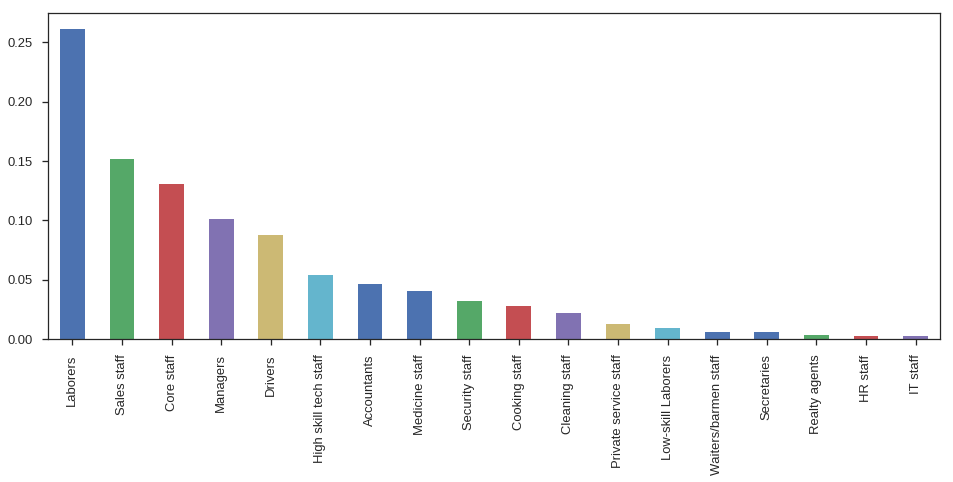

In [21]:
plt.figure(figsize=(16, 6))
app_train.OCCUPATION_TYPE.value_counts(normalize=True).plot(kind='bar');

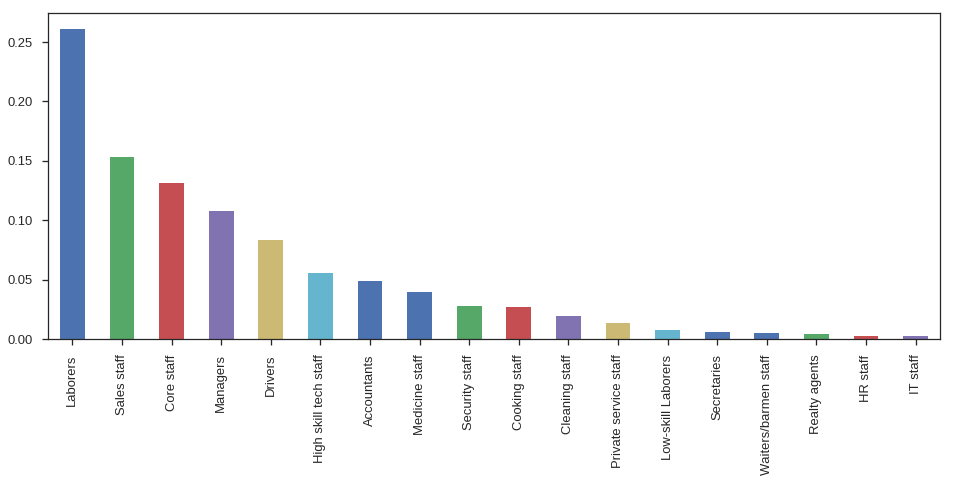

In [22]:
plt.figure(figsize=(16, 6))
app_test.OCCUPATION_TYPE.value_counts(normalize=True).plot(kind='bar');

### Relationship between age categorical and Occupation

In [23]:
pd.crosstab(index=age_categorical, 
            columns=app_train.OCCUPATION_TYPE, 
            values=app_train.TARGET, 
            aggfunc=np.sum).fillna(0)

OCCUPATION_TYPE,Accountants,Cleaning staff,Cooking staff,Core staff,Drivers,HR staff,High skill tech staff,IT staff,Laborers,Low-skill Laborers,Managers,Medicine staff,Private service staff,Realty agents,Sales staff,Secretaries,Security staff,Waiters/barmen staff
DAYS_BIRTH,,,,,,,,,,,,,,,,,,
"(20.469, 22.948]",9.0,4.0,11.0,67.0,21.0,1.0,21.0,1.0,108.0,9.0,13.0,17.0,5.0,0.0,115.0,5.0,5.0,12.0
"(22.948, 25.378]",23.0,6.0,23.0,136.0,97.0,4.0,31.0,3.0,297.0,22.0,26.0,25.0,8.0,0.0,203.0,9.0,21.0,22.0
"(25.378, 27.808]",20.0,15.0,38.0,181.0,122.0,6.0,44.0,7.0,407.0,19.0,61.0,36.0,14.0,6.0,283.0,5.0,37.0,20.0
"(27.808, 30.238]",61.0,21.0,73.0,219.0,165.0,4.0,79.0,3.0,566.0,39.0,81.0,44.0,20.0,9.0,356.0,11.0,37.0,19.0
"(30.238, 32.668]",57.0,27.0,61.0,168.0,170.0,3.0,62.0,6.0,562.0,36.0,152.0,47.0,24.0,8.0,303.0,8.0,49.0,14.0
"(32.668, 35.099]",41.0,28.0,47.0,137.0,146.0,2.0,56.0,4.0,536.0,38.0,129.0,34.0,15.0,12.0,283.0,6.0,54.0,11.0
"(35.099, 37.529]",42.0,40.0,63.0,140.0,165.0,1.0,62.0,3.0,549.0,28.0,111.0,57.0,17.0,6.0,271.0,9.0,52.0,12.0
"(37.529, 39.959]",26.0,25.0,58.0,128.0,184.0,4.0,51.0,0.0,522.0,33.0,121.0,51.0,7.0,3.0,264.0,10.0,44.0,12.0
"(39.959, 42.389]",37.0,30.0,38.0,124.0,174.0,4.0,50.0,1.0,434.0,25.0,106.0,54.0,14.0,4.0,220.0,9.0,50.0,4.0


In [24]:
pd.crosstab(index=age_categorical, 
            columns=app_train.OCCUPATION_TYPE, 
            values=app_train.TARGET, 
            aggfunc=np.mean).fillna(0)

OCCUPATION_TYPE,Accountants,Cleaning staff,Cooking staff,Core staff,Drivers,HR staff,High skill tech staff,IT staff,Laborers,Low-skill Laborers,Managers,Medicine staff,Private service staff,Realty agents,Sales staff,Secretaries,Security staff,Waiters/barmen staff
DAYS_BIRTH,,,,,,,,,,,,,,,,,,
"(20.469, 22.948]",0.079651,0.266602,0.114563,0.105530,0.120667,0.142822,0.128052,0.083313,0.144531,0.281250,0.151123,0.154541,0.094360,0.000000,0.124329,0.151489,0.135132,0.117676
"(22.948, 25.378]",0.082153,0.157837,0.149292,0.096863,0.162720,0.160034,0.066833,0.078918,0.139160,0.186401,0.082825,0.114685,0.083313,0.000000,0.120056,0.125000,0.143799,0.150635
"(25.378, 27.808]",0.041931,0.211304,0.149048,0.086792,0.143921,0.142822,0.062500,0.104492,0.135132,0.153198,0.086182,0.120789,0.095886,0.089539,0.123535,0.052094,0.179565,0.148193
"(27.808, 30.238]",0.071350,0.181030,0.197876,0.083984,0.142456,0.095215,0.084961,0.038452,0.138062,0.209717,0.067322,0.095459,0.090881,0.134277,0.122864,0.080322,0.147949,0.139648
"(30.238, 32.668]",0.066223,0.177612,0.146973,0.065063,0.129028,0.053558,0.063416,0.113220,0.129395,0.197754,0.097961,0.098511,0.103027,0.098755,0.113464,0.060608,0.160645,0.133301
"(32.668, 35.099]",0.050446,0.134644,0.125366,0.060181,0.110718,0.036377,0.071594,0.078430,0.126953,0.220947,0.080627,0.069824,0.068787,0.169067,0.115662,0.057129,0.153442,0.117004
"(35.099, 37.529]",0.048553,0.162598,0.132935,0.064819,0.116089,0.020004,0.073792,0.047607,0.119812,0.137939,0.062683,0.087585,0.072632,0.103455,0.101929,0.084900,0.129028,0.123718
"(37.529, 39.959]",0.031982,0.086792,0.117859,0.057098,0.113220,0.076904,0.055725,0.000000,0.106323,0.184326,0.063171,0.065552,0.028564,0.046143,0.094543,0.099976,0.096252,0.119995
"(39.959, 42.389]",0.050751,0.101379,0.076782,0.060822,0.110107,0.108093,0.058472,0.045441,0.095886,0.161255,0.052307,0.071533,0.056213,0.053345,0.083923,0.090881,0.102478,0.048767


### Relationship between employemnt and occcupation type

In [5]:
pd.crosstab(index=emp_categorical, 
            columns=app_train.OCCUPATION_TYPE, 
            values=app_train.TARGET, 
            aggfunc=np.sum).fillna(0)

OCCUPATION_TYPE,Accountants,Cleaning staff,Cooking staff,Core staff,Drivers,HR staff,High skill tech staff,IT staff,Laborers,Low-skill Laborers,Managers,Medicine staff,Private service staff,Realty agents,Sales staff,Secretaries,Security staff,Waiters/barmen staff
DAYS_EMPLOYED,,,,,,,,,,,,,,,,,,
"(-0.0491, 3.272]",193.0,227.0,314.0,794.0,1121.0,18.0,322.0,21.0,2824.0,221.0,537.0,194.0,78.0,32.0,1684.0,40.0,372.0,90.0
"(3.272, 6.543]",150.0,121.0,167.0,452.0,548.0,10.0,171.0,9.0,1490.0,81.0,379.0,129.0,55.0,13.0,860.0,24.0,199.0,36.0
"(6.543, 9.815]",67.0,58.0,75.0,193.0,244.0,4.0,96.0,2.0,757.0,38.0,197.0,76.0,21.0,11.0,355.0,9.0,72.0,14.0
"(9.815, 13.086]",32.0,16.0,33.0,106.0,97.0,2.0,36.0,1.0,337.0,10.0,92.0,58.0,7.0,3.0,119.0,8.0,38.0,5.0
"(13.086, 16.358]",10.0,9.0,16.0,64.0,51.0,0.0,25.0,0.0,190.0,7.0,50.0,39.0,4.0,0.0,51.0,8.0,20.0,5.0
"(16.358, 19.63]",5.0,4.0,5.0,44.0,16.0,0.0,13.0,0.0,92.0,2.0,29.0,27.0,5.0,0.0,11.0,0.0,8.0,1.0
"(19.63, 22.901]",5.0,6.0,7.0,38.0,11.0,0.0,11.0,0.0,60.0,0.0,18.0,19.0,1.0,0.0,3.0,2.0,8.0,1.0
"(22.901, 26.173]",5.0,3.0,1.0,22.0,13.0,1.0,10.0,0.0,32.0,0.0,10.0,15.0,1.0,0.0,3.0,1.0,4.0,0.0
"(26.173, 29.444]",3.0,2.0,3.0,15.0,2.0,0.0,6.0,0.0,23.0,0.0,2.0,7.0,3.0,0.0,4.0,0.0,0.0,0.0


In [6]:
pd.crosstab(index=emp_categorical, 
            columns=app_train.OCCUPATION_TYPE, 
            values=app_train.TARGET, 
            aggfunc=np.mean).fillna(0)

OCCUPATION_TYPE,Accountants,Cleaning staff,Cooking staff,Core staff,Drivers,HR staff,High skill tech staff,IT staff,Laborers,Low-skill Laborers,Managers,Medicine staff,Private service staff,Realty agents,Sales staff,Secretaries,Security staff,Waiters/barmen staff
DAYS_EMPLOYED,,,,,,,,,,,,,,,,,,
"(-0.0491, 3.272]",0.054504,0.114929,0.124023,0.082336,0.136841,0.080017,0.078857,0.093323,0.135010,0.199829,0.084351,0.094360,0.082886,0.101929,0.111938,0.082153,0.121826,0.143555
"(3.272, 6.543]",0.059967,0.098694,0.106628,0.070129,0.107239,0.067566,0.063782,0.061646,0.107788,0.161987,0.069702,0.072571,0.069702,0.053497,0.095154,0.080566,0.111450,0.101379
"(6.543, 9.815]",0.039276,0.089661,0.091370,0.048981,0.090515,0.053345,0.054840,0.026321,0.087708,0.146118,0.051453,0.062439,0.045654,0.093994,0.076782,0.043060,0.078247,0.073669
"(9.815, 13.086]",0.034210,0.049530,0.083313,0.043182,0.078979,0.038452,0.037354,0.032257,0.072388,0.085449,0.042206,0.065918,0.032715,0.071411,0.059113,0.081604,0.078186,0.065796
"(13.086, 16.358]",0.021103,0.047363,0.070496,0.040985,0.078003,0.000000,0.041595,0.000000,0.068909,0.125000,0.034332,0.055634,0.033600,0.000000,0.057678,0.112671,0.083313,0.108704
"(16.358, 19.63]",0.023590,0.032013,0.037598,0.039673,0.057983,0.000000,0.036407,0.000000,0.069702,0.080017,0.035278,0.049805,0.098022,0.000000,0.038727,0.000000,0.089905,0.038452
"(19.63, 22.901]",0.031052,0.077942,0.059326,0.042847,0.054199,0.000000,0.039703,0.000000,0.053772,0.000000,0.033966,0.041382,0.034485,0.000000,0.024994,0.068970,0.135620,0.071411
"(22.901, 26.173]",0.049500,0.096802,0.016953,0.034760,0.136841,0.125000,0.051025,0.000000,0.049469,0.000000,0.037750,0.045166,0.058838,0.000000,0.061218,0.034485,0.148193,0.000000
"(26.173, 29.444]",0.049988,0.076904,0.051727,0.039886,0.039215,0.000000,0.036377,0.000000,0.048126,0.000000,0.011047,0.029663,0.230713,0.000000,0.190430,0.000000,0.000000,0.000000


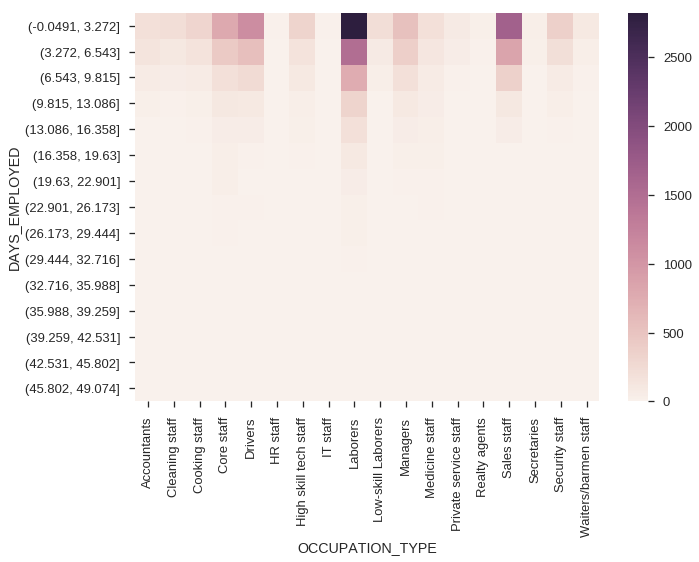

In [8]:
sns.heatmap(pd.crosstab(index=emp_categorical, 
            columns=app_train.OCCUPATION_TYPE, 
            values=app_train.TARGET, 
            aggfunc=np.sum).fillna(0));

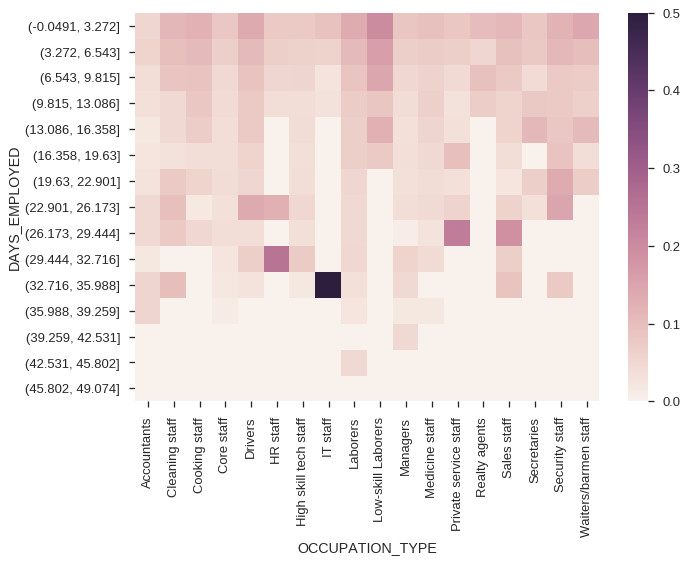

In [7]:
sns.heatmap(pd.crosstab(index=emp_categorical, 
            columns=app_train.OCCUPATION_TYPE, 
            values=app_train.TARGET, 
            aggfunc=np.mean).fillna(0));

### Compare refused previous applications with current application.

In [22]:
# How many current applicants have data for previous applications
res = app_train.loc[:, ['SK_ID_CURR']]\
               .merge(prev_app.loc[:, ['SK_ID_CURR', 'NAME_CONTRACT_STATUS']], how='left')
    
print('{} fraction of people have data for previous applications'.format(res[res.NAME_CONTRACT_STATUS.notnull()].shape[0] / len(res)))

0.9884949533442179 fraction of people have data for previous applications


98.9% of people have made an application to Home Credit prior to the current application.

In [23]:
# How many of them have had their application refused in the past
res = app_train.loc[:, ['SK_ID_CURR']]\
               .merge(prev_app.loc[prev_app.NAME_CONTRACT_STATUS == 'Refused', ['SK_ID_CURR', 'NAME_CONTRACT_STATUS']], how='left')

print('{} fraction of people who have had their application refused in the past'.format(res[res.NAME_CONTRACT_STATUS.notnull()].shape[0] / len(res)))

0.5421701387738148 fraction of people who have had their application refused in the past


54.21 % of people have had their application refused in the past.

In [30]:
refused_mask  = (prev_app.NAME_CONTRACT_STATUS == 'Refused')
approved_mask = (prev_app.NAME_CONTRACT_STATUS == 'Approved')

In [31]:
prev_app.loc[refused_mask, 'NAME_CONTRACT_TYPE'].value_counts(normalize=True)

Cash loans         0.570831
Consumer loans     0.258654
Revolving loans    0.170408
XNA                0.000107
Name: NAME_CONTRACT_TYPE, dtype: float64

In [32]:
prev_app.loc[approved_mask, 'NAME_CONTRACT_TYPE'].value_counts(normalize=True)

Consumer loans     0.604245
Cash loans         0.301452
Revolving loans    0.094302
XNA                0.000000
Name: NAME_CONTRACT_TYPE, dtype: float64

### Annuity

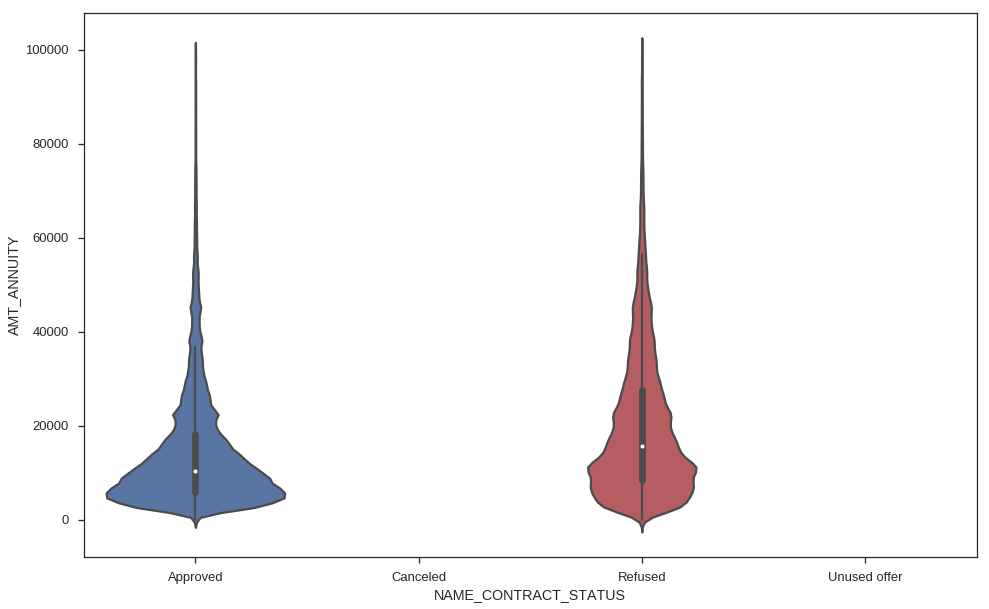

In [43]:
plt.figure(figsize=(16, 10))
sns.violinplot(y='AMT_ANNUITY', x='NAME_CONTRACT_STATUS', 
               data=prev_app.loc[(prev_app.NAME_CONTRACT_STATUS.isin(['Approved', 'Refused'])) &\
                                 (prev_app.AMT_ANNUITY < 100000)
                                ]);

#### Amount Credit

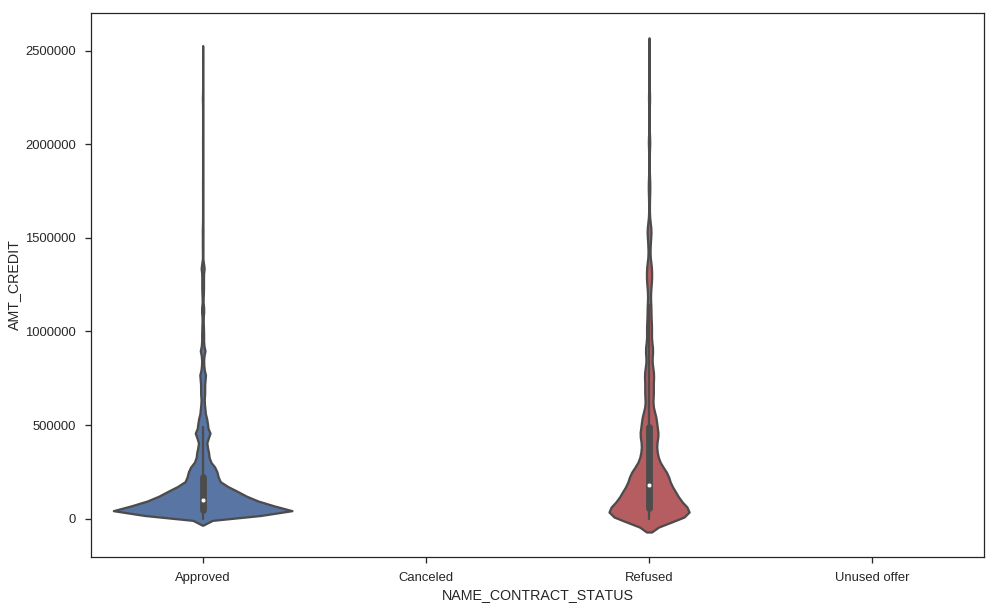

In [45]:
plt.figure(figsize=(16, 10))
sns.violinplot(y='AMT_CREDIT', x='NAME_CONTRACT_STATUS', 
               data=prev_app.loc[(prev_app.NAME_CONTRACT_STATUS.isin(['Approved', 'Refused'])) &\
                                 (prev_app.AMT_CREDIT < 2500000)
                                ]);

### Payment Rate

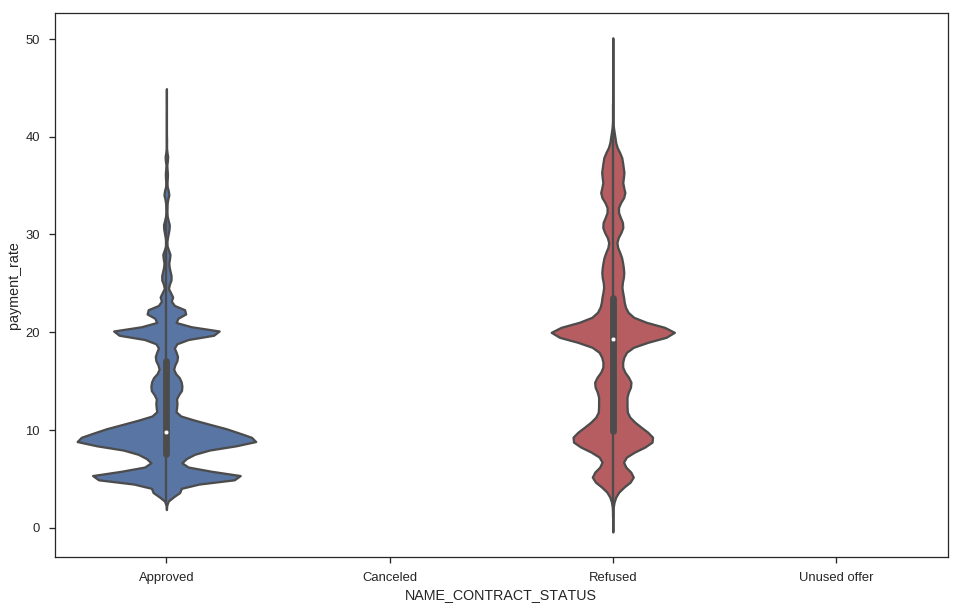

In [48]:
plt.figure(figsize=(16, 10))
df = prev_app.loc[(prev_app.NAME_CONTRACT_STATUS.isin(['Approved', 'Refused']))]
df.loc[:, 'payment_rate'] = (df.AMT_CREDIT / df.AMT_ANNUITY).replace([np.inf, -np.inf], np.nan)

sns.violinplot(y='payment_rate', x='NAME_CONTRACT_STATUS', 
               data=df[df.payment_rate < 50]);

### Down Payment

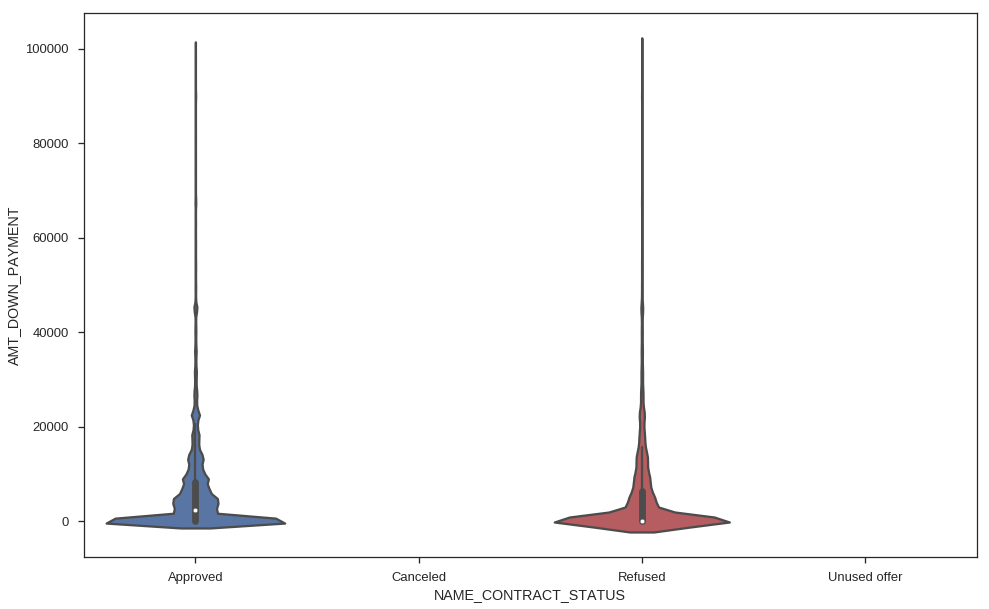

In [56]:
plt.figure(figsize=(16, 10))
sns.violinplot(y='AMT_DOWN_PAYMENT', x='NAME_CONTRACT_STATUS', 
               data=prev_app.loc[(prev_app.NAME_CONTRACT_STATUS.isin(['Approved', 'Refused'])) &\
                                 (prev_app.AMT_DOWN_PAYMENT < 100000)
                                ]);

### Goods price

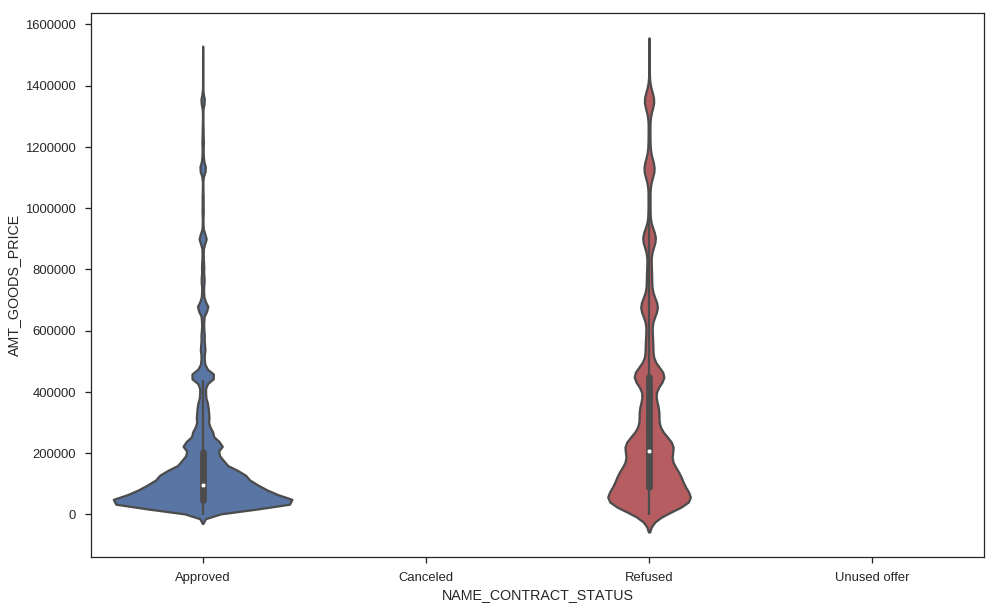

In [58]:
plt.figure(figsize=(16, 10))
sns.violinplot(y='AMT_GOODS_PRICE', x='NAME_CONTRACT_STATUS', 
               data=prev_app.loc[(prev_app.NAME_CONTRACT_STATUS.isin(['Approved', 'Refused'])) &\
                                 (prev_app.AMT_GOODS_PRICE < 1500000)
                                ]);

### Difference between payment rate between approved and refused applications for applicants.

In [79]:
r1 = (prev_app.loc[prev_app.NAME_CONTRACT_STATUS == 'Approved', 'AMT_ANNUITY'] /\
     prev_app.loc[prev_app.NAME_CONTRACT_STATUS == 'Approved', 'AMT_CREDIT']).replace([np.inf, -np.inf], np.nan)
r1 = r1.reset_index()
r1.loc[:, 'index'] = prev_app.loc[prev_app.NAME_CONTRACT_STATUS == 'Approved', 'SK_ID_CURR'].values
r1 = r1.rename(columns={'index': 'SK_ID_CURR',
                        0: 'payment_rate'
                       })
r1 = r1.groupby('SK_ID_CURR')['payment_rate'].max()

r2 = (prev_app.loc[prev_app.NAME_CONTRACT_STATUS == 'Refused', 'AMT_ANNUITY'] /\
      prev_app.loc[prev_app.NAME_CONTRACT_STATUS == 'Refused', 'AMT_CREDIT']).replace([np.inf, -np.inf], np.nan)

r2 = r2.reset_index()
r2.loc[:, 'index'] = prev_app.loc[prev_app.NAME_CONTRACT_STATUS == 'Refused', 'SK_ID_CURR'].values
r2 = r2.rename(columns={'index': 'SK_ID_CURR',
                        0: 'payment_rate'
                       })
r2 = r2.groupby('SK_ID_CURR')['payment_rate'].min()

res = r1.subtract(r2, fill_value=np.nan)
res = app_train.SK_ID_CURR.map(res)

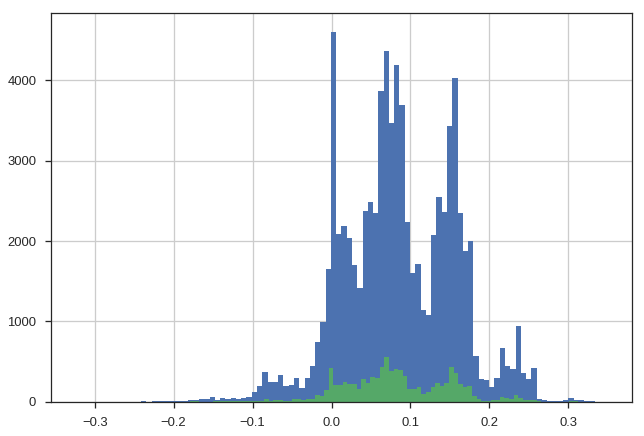

In [81]:
res[app_train.TARGET == 0].hist(bins=100)
res[app_train.TARGET == 1].hist(bins=100);

### Difference between credit amount of approved and refused applications.

In [89]:
r1 = prev_app.loc[prev_app.NAME_CONTRACT_STATUS == 'Approved', ['SK_ID_CURR', 'AMT_CREDIT']]
r1 = r1.groupby('SK_ID_CURR')['AMT_CREDIT'].max()

r2 = prev_app.loc[prev_app.NAME_CONTRACT_STATUS == 'Refused', ['SK_ID_CURR', 'AMT_CREDIT']]
r2 = r2.groupby('SK_ID_CURR')['AMT_CREDIT'].min()

res = r1.subtract(r2, fill_value=np.nan)
res = app_train.SK_ID_CURR.map(res)

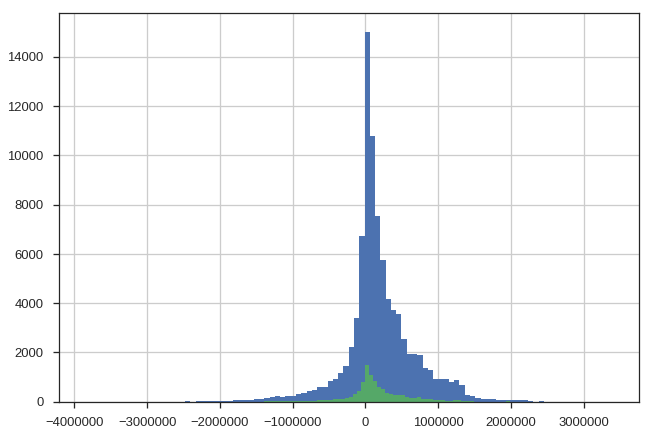

In [90]:
res[app_train.TARGET == 0].hist(bins=100)
res[app_train.TARGET == 1].hist(bins=100);

### Difference between goods price of approved and refused applications.

In [91]:
r1 = prev_app.loc[prev_app.NAME_CONTRACT_STATUS == 'Approved', ['SK_ID_CURR', 'AMT_GOODS_PRICE']]
r1 = r1.groupby('SK_ID_CURR')['AMT_GOODS_PRICE'].max()

r2 = prev_app.loc[prev_app.NAME_CONTRACT_STATUS == 'Refused', ['SK_ID_CURR', 'AMT_GOODS_PRICE']]
r2 = r2.groupby('SK_ID_CURR')['AMT_GOODS_PRICE'].min()

res = r1.subtract(r2, fill_value=np.nan)
res = app_train.SK_ID_CURR.map(res)

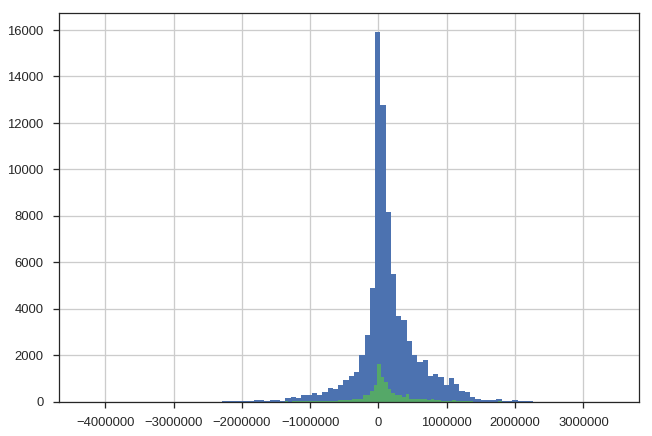

In [96]:
res[app_train.TARGET == 0].hist(bins=100)
res[app_train.TARGET == 1].hist(bins=100)

### Previous application and Installments

In [81]:
# applications currently running
res = prev_app.loc[(prev_app.NAME_CONTRACT_STATUS == 'Approved') &\
                   (prev_app.DAYS_TERMINATION > 0)
                  ]

res = res.loc[:, ['SK_ID_CURR', 'SK_ID_PREV']]\
         .merge(installments.loc[:, ['SK_ID_CURR', 'SK_ID_PREV', 'DAYS_INSTALMENT', 'DAYS_ENTRY_PAYMENT']])
    
res.loc[:, 'diff'] = res.DAYS_INSTALMENT - res.DAYS_ENTRY_PAYMENT
res                = res.groupby('SK_ID_CURR')['diff'].max()
res                = app_train.SK_ID_CURR.map(res)

In [82]:
res[res.isnull()].shape[0] / len(res)

0.5601360601734572

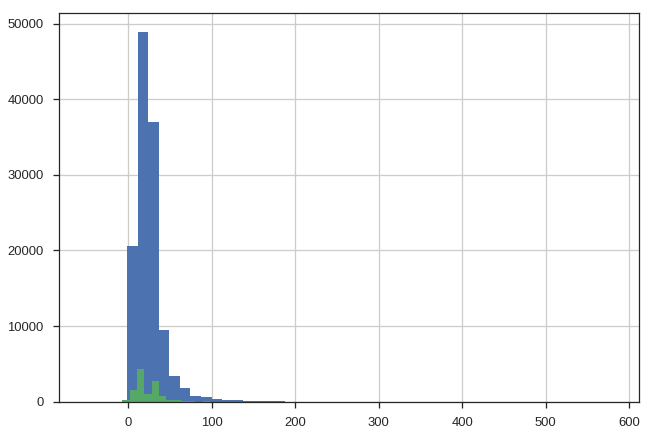

In [83]:
res[app_train.TARGET == 0].hist(bins=50)
res[app_train.TARGET == 1].hist(bins=50);

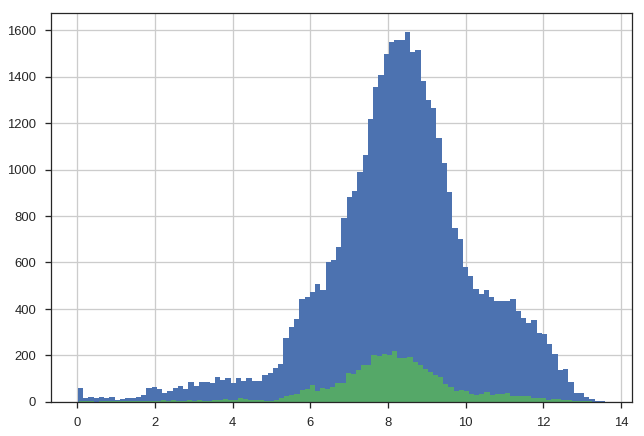

In [54]:
res[(res > 0) & (app_train.TARGET == 0)].map(np.log1p).hist(bins=100)
res[(res > 0) & (app_train.TARGET == 1)].map(np.log1p).hist(bins=100)

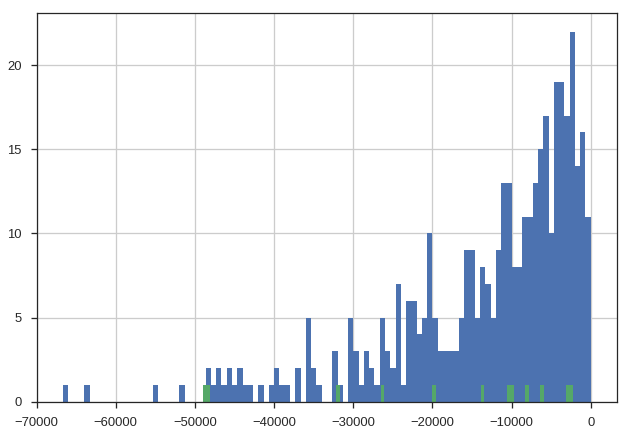

In [46]:
res[(res < 0) & (app_train.TARGET == 0)].hist(bins=100)
res[(res < 0) & (app_train.TARGET == 1)].hist(bins=100);

### Relationship between previous application and credit balance.

In [21]:
res = prev_app.loc[prev_app.NAME_CONTRACT_STATUS == 'Approved', ['SK_ID_CURR',
                                                         'SK_ID_PREV']]\
        .merge(credit_bal.loc[credit_bal.MONTHS_BALANCE > -12, 
                              ['SK_ID_CURR', 'SK_ID_PREV', 'CNT_DRAWINGS_ATM_CURRENT'
                              ]])
res  = res.groupby('SK_ID_CURR')['CNT_DRAWINGS_ATM_CURRENT'].sum()
res  = app_train.SK_ID_CURR.map(res)

In [22]:
res[res.isnull()].shape[0] / len(res)

0.7465651635226057

In [23]:
ss = pd.crosstab(res, app_train.TARGET)
ss.loc[:, 'ratio'] = ss[1] / (ss[0] + ss[1])
print(ss)

del ss
gc.collect();

TARGET        0.0   1.0     ratio
SK_ID_CURR                       
0.0         48303  3380  0.065399
1.0          2682   289  0.097274
2.0          2332   282  0.107881
3.0          2133   266  0.110880
4.0          1866   248  0.117313
5.0          1656   281  0.145070
6.0          1422   272  0.160567
7.0          1341   222  0.142035
8.0          1196   212  0.150568
9.0          1070   169  0.136400
10.0          883   151  0.146035
11.0          759   130  0.146232
12.0          681   131  0.161330
13.0          530   105  0.165354
14.0          501   114  0.185366
15.0          381    89  0.189362
16.0          372    88  0.191304
17.0          335    63  0.158291
18.0          288    55  0.160350
19.0          236    49  0.171930
20.0          195    44  0.184100
21.0          181    40  0.180995
22.0          155    43  0.217172
23.0          151    30  0.165746
24.0          128    30  0.189873
25.0           88    26  0.228070
26.0           93    23  0.198276
27.0          

### Relationship between first loan reported to Bureau and days since employed

In [38]:
oldest_credit = bureau.loc[bureau.DAYS_ENDDATE_FACT.isnull(), :].groupby('SK_ID_CURR')['DAYS_CREDIT'].min()
oldest_credit = app_train.SK_ID_CURR.map(oldest_credit)
print(oldest_credit[oldest_credit.isnull()].shape[0] / len(oldest_credit))
res           = oldest_credit - app_train.DAYS_EMPLOYED.replace({365243: np.nan})

0.2930204122779348


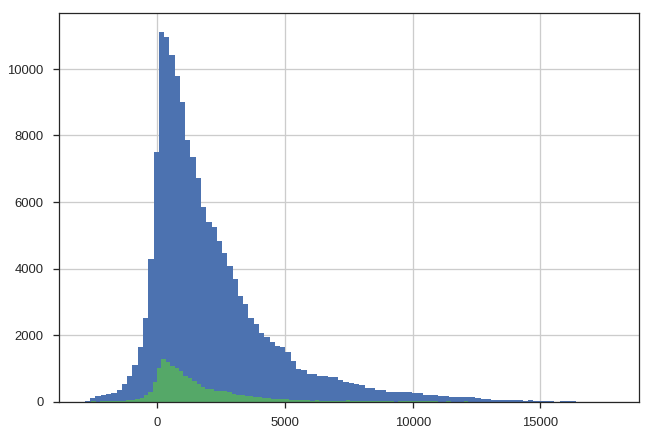

In [39]:
res[app_train.TARGET == 0].hist(bins=100)
res[app_train.TARGET == 1].hist(bins=100);

In [44]:
oldest_credit = bureau.loc[bureau.DAYS_ENDDATE_FACT.isnull(), :].groupby('SK_ID_CURR')['DAYS_CREDIT'].min()
oldest_credit = app_train.SK_ID_CURR.map(oldest_credit)
print(oldest_credit[oldest_credit.isnull()].shape[0] / len(oldest_credit))
res           = oldest_credit - app_train.DAYS_BIRTH

0.2930204122779348


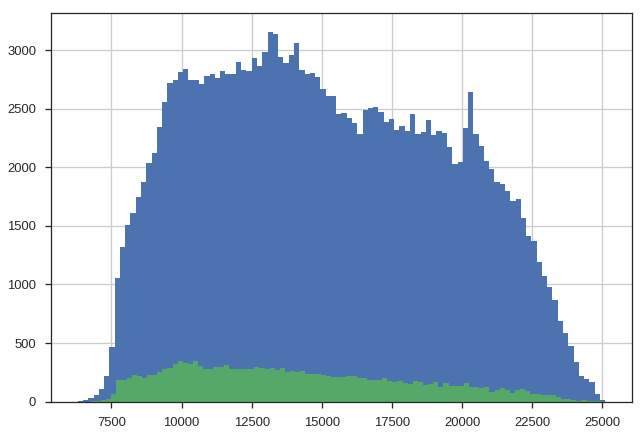

In [45]:
res[app_train.TARGET == 0].hist(bins=100)
res[app_train.TARGET == 1].hist(bins=100);

### Status of credit bureau credits

In [5]:
bureau.CREDIT_ACTIVE.value_counts()

Closed      1079273
Active       630607
Sold           6527
Bad debt         21
Name: CREDIT_ACTIVE, dtype: int64

In [15]:
bureau.CREDIT_ACTIVE.cat.codes.value_counts()

2    1079273
0     630607
3       6527
1         21
dtype: int64

In [10]:
# most recently closed credits for a user
res = bureau.loc[bureau.CREDIT_ACTIVE == 'Closed'].groupby('SK_ID_CURR')['DAYS_ENDDATE_FACT'].max()
res = app_train.SK_ID_CURR.map(res)

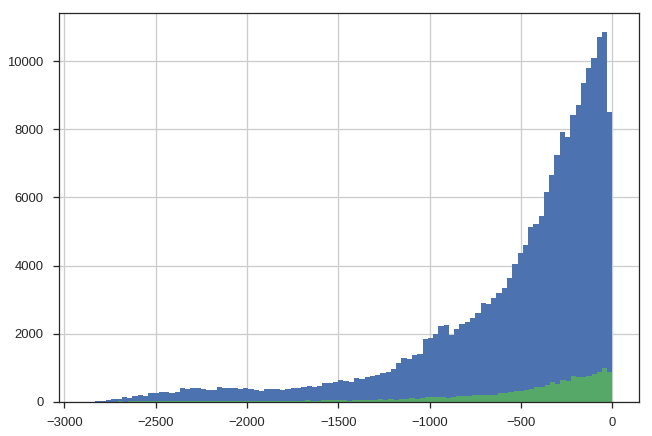

In [14]:
res[app_train.TARGET == 0].hist(bins=100)
res[app_train.TARGET == 1].hist(bins=100)

In [21]:
res = bureau.loc[(bureau.CREDIT_ACTIVE == 'Closed') &\
           (bureau.DAYS_ENDDATE_FACT > -365)
          ].groupby('SK_ID_CURR').size()
res = app_train.SK_ID_CURR.map(res)

print('Null values: {}'.format(res[res.isnull()].shape[0] / len(res)))

ss  = pd.crosstab(res, app_train.TARGET)
ss.loc[:, 'ratio'] = ss[1] / (ss[0] + ss[1])
print(ss)

del ss
gc.collect();

Null values: 0.6121146885802459
TARGET        0.0   1.0     ratio
SK_ID_CURR                       
1.0         69242  5379  0.072084
2.0         25588  2199  0.079138
3.0          9147   828  0.083008
4.0          3358   372  0.099732
5.0          1335   149  0.100404
6.0           601   102  0.145092
7.0           270    44  0.140127
8.0           180    36  0.166667
9.0           100    23  0.186992
10.0           75    17  0.184783
11.0           48    17  0.261538
12.0           33     8  0.195122
13.0           27     6  0.181818
14.0           17     5  0.227273
15.0           11     2  0.153846
16.0           10     3  0.230769
17.0            5     1  0.166667
18.0            4     2  0.333333
19.0            6     1  0.142857
20.0            4     1  0.200000
21.0            5     1  0.166667
22.0            1     0  0.000000
23.0            3     0  0.000000
24.0            2     0  0.000000
25.0            4     1  0.200000
27.0            3     0  0.000000
31.0            

In [92]:
tmp = bureau.loc[(bureau.CREDIT_ACTIVE == 'Closed') &\
                 (bureau.DAYS_CREDIT > -365)
                 , ['SK_ID_CURR', 'DAYS_CREDIT', 'DAYS_ENDDATE_FACT']]
duration_closed_credits = -(tmp.DAYS_CREDIT - tmp.DAYS_ENDDATE_FACT)
r1  = duration_closed_credits.groupby(tmp.SK_ID_CURR).mean()

tmp = bureau.loc[(bureau.CREDIT_ACTIVE == 'Active') &\
                 (bureau.DAYS_CREDIT > -365)
                 , ['SK_ID_CURR', 'DAYS_CREDIT', 'DAYS_CREDIT_ENDDATE']]
duration_active_credits = -(tmp.DAYS_CREDIT - tmp.DAYS_CREDIT_ENDDATE)
r2  = duration_active_credits.groupby(tmp.SK_ID_CURR).mean()

In [93]:
res = app_train.SK_ID_CURR.map(r2 / r1).replace([np.inf, -np.inf], np.nan)
print(res[res.isnull()].shape[0] / len(res))

0.9156257824923336


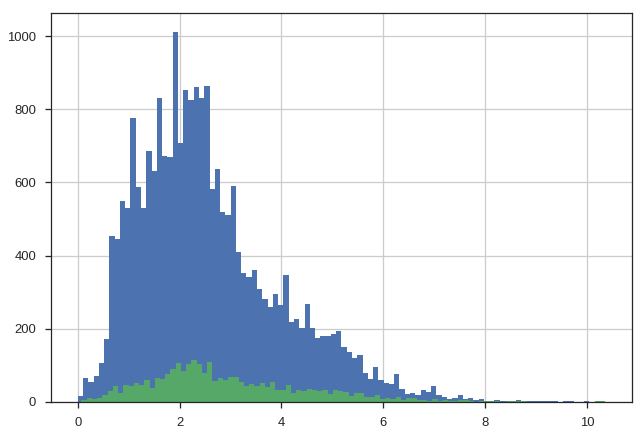

In [94]:
res[app_train.TARGET == 0].map(np.log1p).hist(bins=100)
res[app_train.TARGET == 1].map(np.log1p).hist(bins=100);

### Days past due on credit card payments

In [22]:
res = credit_bal.loc[(credit_bal.MONTHS_BALANCE > -9) 
               , :].groupby('SK_ID_CURR')['SK_DPD'].sum()

res = app_train.SK_ID_CURR.map(res).fillna(0)
print(res[res.isnull()].shape[0] / len(res))

0.0


In [24]:
ss = pd.crosstab(res, app_train.TARGET)
ss.loc[:, 'ratio'] = ss[1] / (ss[0] + ss[1])
ss = ss.sort_index()

print(ss)
del ss
gc.collect()

TARGET         0.0    1.0     ratio
SK_ID_CURR                         
0.0         280378  24420  0.080119
1.0            324     39  0.107438
2.0            103     14  0.119658
3.0             54      4  0.068966
4.0             30      3  0.090909
5.0            108     26  0.194030
6.0              6      1  0.142857
7.0            173     61  0.260684
8.0            268     61  0.185410
9.0              2      0  0.000000
10.0             2      0  0.000000
11.0             1      0  0.000000
12.0            17      4  0.190476
13.0            20      3  0.130435
14.0             8      1  0.111111
15.0            42     14  0.250000
16.0            46     11  0.192982
18.0           110     25  0.185185
19.0            34     11  0.244444
20.0             3      3  0.500000
21.0             2      0  0.000000
22.0             3      2  0.400000
23.0            14      6  0.300000
24.0             2      2  0.500000
26.0            14      3  0.176471
27.0             1      0  0

157

In [25]:
res = credit_bal.loc[(credit_bal.MONTHS_BALANCE > -9) 
               , :].groupby('SK_ID_CURR')['SK_DPD'].mean()

res = app_train.SK_ID_CURR.map(res).fillna(0)
print(res[res.isnull()].shape[0] / len(res))

0.0


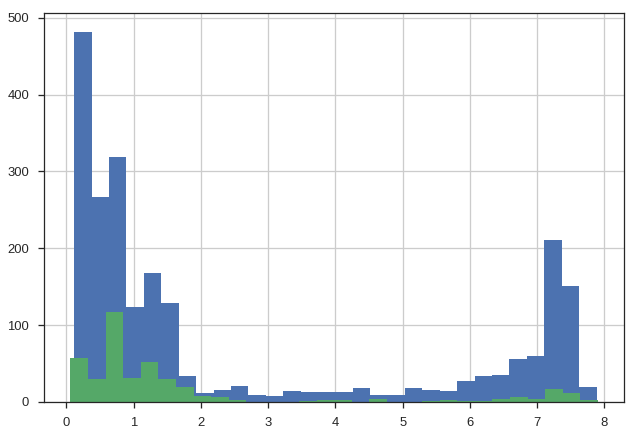

In [31]:
res[(res > 0) & (app_train.TARGET == 0)].map(np.log1p).hist(bins=30)
res[(res > 0) & (app_train.TARGET == 1)].map(np.log1p).hist(bins=30);